# Chapter 8 - Deep Learning For Coders with fastai & 
> FastBook Chapter 8 Collaborative Filtering Deep Dive Recommender systems are different considering the area they used. They are mostly used for known data,no prediction expected based on unknown data like bear classifier. Yes there is a generalization process but still, all data is known by the model. What is not known is latent factors at the beginning. The model learn these latent factors and recommender is ready.Real questions are what happens when a new user get into a system and what happens when a new movie added into the inventory.
- toc: true 
- badges: true
- comments: true
- categories: [fastbook]
- image: images/fastbook_images/chapter-08/my_dougther.jpg

![](images/chapter-08/my_dougther.jpg)
This my dougther at the IKEA very close our home.

In [1]:
import fastbook
fastbook.setup_book()
from fastbook import *

In [2]:
%config Completer.use_jedi = False

Collaborative filtering modules

## Exploring the data

In [3]:
from fastai.collab import *
from fastai.tabular.all import*

Downloading and extracting data from the URL list

In [4]:
path = untar_data(URLs.ML_100k)

Giving columns names and readind first five rows.

In [5]:
ratings = pd.read_csv(path/'u.data',delimiter = '\t', header= None, engine='python',names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


How to recommend movies.
Assume the movie has three properties, scince fiction(ness), action, old(ness).

Last skywalker is a sci-fi, and action and not old.

## How model learn about our preferences

In [6]:
last_skywalker = np.array([0.98,0.9,-0.9])

And a user  who likes sci-fi and action movies and not so old movies would like this.

In [7]:
user1= np.array([.9,.8,-.6])

If we multiply these two vectors and sum it. We get:

In [8]:
(user1*last_skywalker).sum()

2.1420000000000003

this our matching score, it is a positive value it shows there is a match between the movie and the user1

In [9]:
casablanka= np.array([-.99,-.33,.8])

In [10]:
(user1*casablanka).sum()

-1.635

this is low at this time. There is no match.

### Latent Factors

We can pick arbitrary number of parameters in the array. Above, we use three of them. That could be much more of them. We call them **Latent Factors**. We start training  with random parameters  and learn from ratings by given users. 

## How to create Dataloaders

> Note: It is not easy to use data as it was. For this dataset, movie id and movie title are not on the same table. 

In [11]:
movies = pd.read_csv(path/'u.item', delimiter='|', engine= 'python',header=None,encoding='latin1', usecols=(0,1),names=('movie','title'))
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


**Let's bring ratings and movies together.** (movie id will be the key parameter)

In [12]:
ratings=ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


For Dataloaders, we use `CollabDataLoaders` this Dataloader use first column for the user and second one for the `item`, in our situation we should change the default one because our `item` will be `title`.

In [13]:
dls=CollabDataLoaders.from_df(ratings, item_name='title',bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [14]:
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [15]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5
user_factors = torch.randn(n_users,n_factors)
movie_factors = torch.randn(n_movies, n_factors)

## More PyTorch Less Python

> Tip: This is how one_hot works.

In [16]:
one_hot(0,5)

tensor([1, 0, 0, 0, 0], dtype=torch.uint8)

In [17]:
one_hot_3 = one_hot(3,n_users).float()
one_hot_3[:10]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

and multiply by users_factors(matrix multiplication)

In [18]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

This might look a bit daunting but it is not. Basically we want utilize pytorch more and python less. PyTorch very good at matrix multiplication, python is not. With this matrix multiplication we can access every index of the latent factor tensor in one move. Otherwise we would have use regular python loop and index which is very very slow.

This is Python version:

In [19]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

This is same. Great.

## Collaborative Filtering from Scratch

At this point there is a section regarding OOP if you want to learn OOP the check the original book  page 260 (3rd release) or the course [notebook](https://colab.research.google.com/github/fastai/fastbook/blob/master/08_collab.ipynb) 

In [20]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

> Important: This forward method is a bit confusing but I guess what happens there is, `x` is merged df (it became part of the dls) from above so first column is user id and the second is movie id. check this part:
```python
ratings=ratings.merge(movies)
ratings.head()
```

In [21]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [22]:
x[0]

tensor([661, 659])

first one is user id and the second is movie.

In [23]:
y[0]

tensor([4], dtype=torch.int8)

must be the rating.

### Let's train

In [24]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [25]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:06
1,1.093331,1.109981,00:06
2,0.958258,0.990199,00:06
3,0.814234,0.894916,00:06
4,0.780714,0.882022,00:06


not bad but we can force our model tpredictions into range 0-5

In [26]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [27]:
doc(sigmoid_range)

because the `Learner` dls has values in this range (user rating) and there is a special method in the fastai(I assume) for that.

In [28]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:06
1,0.878134,0.918898,00:06
2,0.675850,0.875467,00:06
3,0.483372,0.877939,00:06
4,0.378927,0.881887,00:06


A little bit better results.

### Bias

Sometimes a user give ratings low generally that thinks movies are bad or the opposite. Let's add a net parameter for that is `bias`. Bias effects all other parameters in negative or positive way.

In [29]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [30]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.938634,0.952516,00:07
1,0.846664,0.865633,00:07
2,0.608090,0.865127,00:07
3,0.413482,0.887318,00:07
4,0.286971,0.894876,00:07


    And the training loss goes down faster and faster, but valid loss not so.

## Weight Decay (or L2 regularization)

from the book:

Weight decay, or *L2 regularization*, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.**

Why would it prevent overfitting? The idea is that the larger the coefficients are, the sharper canyons we will have in the loss function. If we take the basic example of a parabola, `y = a * (x**2)`, the larger `a` is, the more *narrow* the parabola is (<<parabolas>>).
    
So, letting our model learn high parameters might cause it to fit all the data points in the training set with an overcomplex function that has very sharp changes, which will lead to overfitting.

Limiting our weights from growing too much is going to hinder the training of the model, but it will yield a state where it generalizes better. Going back to the theory briefly, weight decay (or just `wd`) is a parameter that controls that sum of squares we add to our loss (assuming `parameters` is a tensor of all parameters):

``` python
loss_with_wd = loss + wd * (parameters**2).sum()
```

In practice, though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. If you remember a little bit of high school math, you might recall that the derivative of `p**2` with respect to `p` is `2*p`, so adding that big sum to our loss is exactly the same as doing:

``` python
parameters.grad += wd * 2 * parameters
```

In practice, since `wd` is a parameter that we choose, we can just make it twice as big, so we don't even need the `*2` in this equation. To use weight decay in fastai, just pass `wd` in your call to `fit` or `fit_one_cycle`:

In [31]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.932776,0.961672,00:07
1,0.888625,0.882614,00:07
2,0.771066,0.832743,00:07
3,0.599807,0.822374,00:07
4,0.504981,0.822528,00:07


Not so good traing loss but at this time validation loss is far better.

### Creating Our Own Embedding Module

In [32]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

There is  no pararameters by its definition parameters must be trainable

In [33]:
type(torch.ones(3)[0])

torch.Tensor

> Note: this is tensor not parameter.So it is not trainable.9 No gradiend tracking.

from the book:

To tell `Module` that we want to treat a tensor as a parameter, we have to wrap it in the `nn.Parameter` class. This class doesn't actually add any functionality (other than automatically calling `requires_grad_` for us). It's only used as a "marker" to show what to include in `parameters`:

In [34]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

and

In [35]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.3292],
        [-0.8623],
        [ 0.0592]], requires_grad=True)]

In [36]:
type(t.a.weight)

torch.nn.parameter.Parameter

> Note: This is a  parameter

In [37]:
type(t.a.weight.data)

torch.Tensor

> Note: This is not.

### Custom Embedding without using Pytorch ``Embedding``

In [38]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [39]:
doc(create_params)

In [40]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [41]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.929254,0.953444,00:09
1,0.865246,0.878304,00:08
2,0.720294,0.838921,00:08
3,0.582796,0.829129,00:08
4,0.474043,0.829031,00:08


Very similiar results.

## Interpreting Embeddings and Biases

Lowest biases in the model.

In [42]:
movie_bias=learn.model.movie_bias.squeeze()
idxs=movie_bias.argsort()[0:5]
[dls.classes['title'][i] for i in idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Amityville 3-D (1983)',
 'Beautician and the Beast, The (1997)']

from the book:

Think about what this means. What it's saying is that for each of these movies, even when a user is very well matched to its latent factors (which, as we will see in a moment, tend to represent things like level of action, age of movie, and so forth), they still generally don't like it. We could have simply sorted the movies directly by their average rating, but looking at the learned bias tells us something much more interesting. It tells us not just whether a movie is of a kind that people tend not to enjoy watching, but that people tend not to like watching it even if it is of a kind that they would otherwise enjoy! By the same token, here are the movies with the highest bias:

In [43]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

from the book:

So, for instance, even if you don't normally enjoy detective movies, you might enjoy *LA Confidential*!

It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. But there is a technique that can pull out the most important underlying *directions* in such a matrix, called *principal component analysis* (PCA). We will not be going into this in detail in this book, because it is not particularly important for you to understand to be a deep learning practitioner, but if you are interested then we suggest you check out the fast.ai course [Computational Linear Algebra for Coders](https://github.com/fastai/numerical-linear-algebra). <<img_pca_movie>> shows what our movies look like based on two of the strongest PCA components.

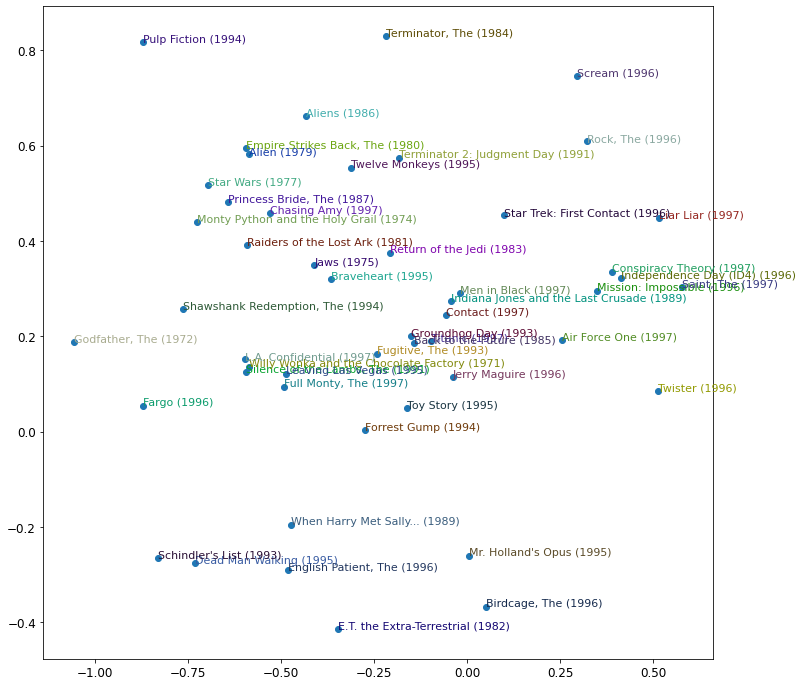

In [44]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Lets try changig X axis.


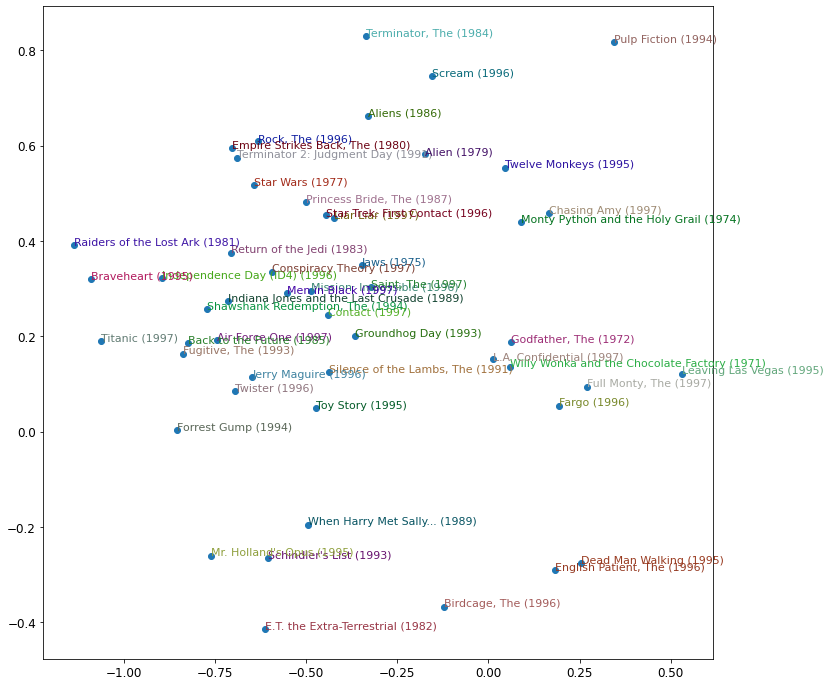

In [46]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac1[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Very interesting to study changes

### Using fastai.collab¶

Same thing with fastai `collab_learner`

In [47]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [48]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.939464,0.954959,00:07
1,0.841215,0.876151,00:07
2,0.724404,0.832099,00:07
3,0.597228,0.816953,00:07
4,0.481373,0.817286,00:07


In [49]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [50]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)']

similar results.

### Embedding Distance

Basically it means if two movies has similar latent factors.(embedding vector)
This is the movie very similar latent factors with Silence of the lambs.

In [52]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Before the Rain (Pred dozhdot) (1994)'

## Bootstrapping a Collaborative Filtering Model

read the all section from the original book at page 270 (3rd release) or the course [notebook](https://colab.research.google.com/github/fastai/fastbook/blob/master/08_collab.ipynb) 

## Deep Learning for Collaborative Filtering

First fastai could make a recommendation for right embedding sizes(latent factors)

In [54]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [55]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [56]:
model = CollabNN(*embs)

In [57]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.943857,0.951898,00:09
1,0.914498,0.900150,00:08
2,0.849329,0.885026,00:08
3,0.813474,0.875370,00:08
4,0.764667,0.877963,00:08


### with one step.

above is possibble(again) with collab_learner with one step. just use `use_nn=True`.

In [58]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.006815,1.002226,00:10
1,0.879284,0.928516,00:10
2,0.885858,0.899841,00:10
3,0.817959,0.874211,00:10
4,0.805374,0.873384,00:10


from the book:

Although the results of EmbeddingNN are a bit worse than the dot product approach (which shows the power of carefully constructing an architecture for a domain), it does allow us to do something very important: we can now directly incorporate other user and movie information, date and time information, or any other information that may be relevant to the recommendation. That's exactly what TabularModel does. In fact, we've now seen that EmbeddingNN is just a TabularModel, with n_cont=0 and out_sz=1. So, we'd better spend some time learning about TabularModel, and how to use it to get great results! We'll do that in the next chapter.